<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-to-test-Walk-Forward-Optimisation-'with-memory'" data-toc-modified-id="Notebook-to-test-Walk-Forward-Optimisation-'with-memory'-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook to test Walk Forward Optimisation 'with memory'</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li></ul></li><li><span><a href="#WF-optimization-with-memory---2000:2020" data-toc-modified-id="WF-optimization-with-memory---2000:2020-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>WF optimization with memory - 2000:2020</a></span><ul class="toc-item"><li><span><a href="#WF-Function" data-toc-modified-id="WF-Function-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>WF Function</a></span></li><li><span><a href="#Definition-of-parameter-combinations" data-toc-modified-id="Definition-of-parameter-combinations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Definition of parameter combinations</a></span></li><li><span><a href="#Long-lists-of-parameters" data-toc-modified-id="Long-lists-of-parameters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Long lists of parameters</a></span></li><li><span><a href="#Short-lists-of-parameters" data-toc-modified-id="Short-lists-of-parameters-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Short lists of parameters</a></span></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Save data</a></span></li><li><span><a href="#Comparing-long-and-short-performance" data-toc-modified-id="Comparing-long-and-short-performance-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Comparing long and short performance</a></span></li><li><span><a href="#Others" data-toc-modified-id="Others-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Others</a></span><ul class="toc-item"><li><span><a href="#Heatmaps-with-widgets" data-toc-modified-id="Heatmaps-with-widgets-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Heatmaps with widgets</a></span></li></ul></li></ul></li></ul></div>

# Notebook to test Walk Forward Optimisation 'with memory'

### Imports

In [1]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;text-align: center;vertical-align: middle;} </style>""")

In [2]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import matplotlib as plt
from tqdm.auto import tqdm, trange
print("Libraries imported correctly")

Libraries imported correctly


In [3]:
os.chdir("/Users/Sergio/Documents/Master_QF/Thesis/Code/Algorithmic Strategies")
%run Functions.ipynb

### Data

In [4]:
ini_equity_default = 100
commision_default = 2/130000 + 12.5/130000 #0.000111538462, around 0.011..% of the equity

Close  Market_daily_ret
Date                                     
2020-12-24  3703.060059          0.003537
2020-12-28  3735.360107          0.008723
2020-12-29  3727.040039         -0.002227
2020-12-30  3732.040039          0.001342
2020-12-31  3756.070068          0.006439

<AxesSubplot:title={'center':'SP500'}, xlabel='Date'>

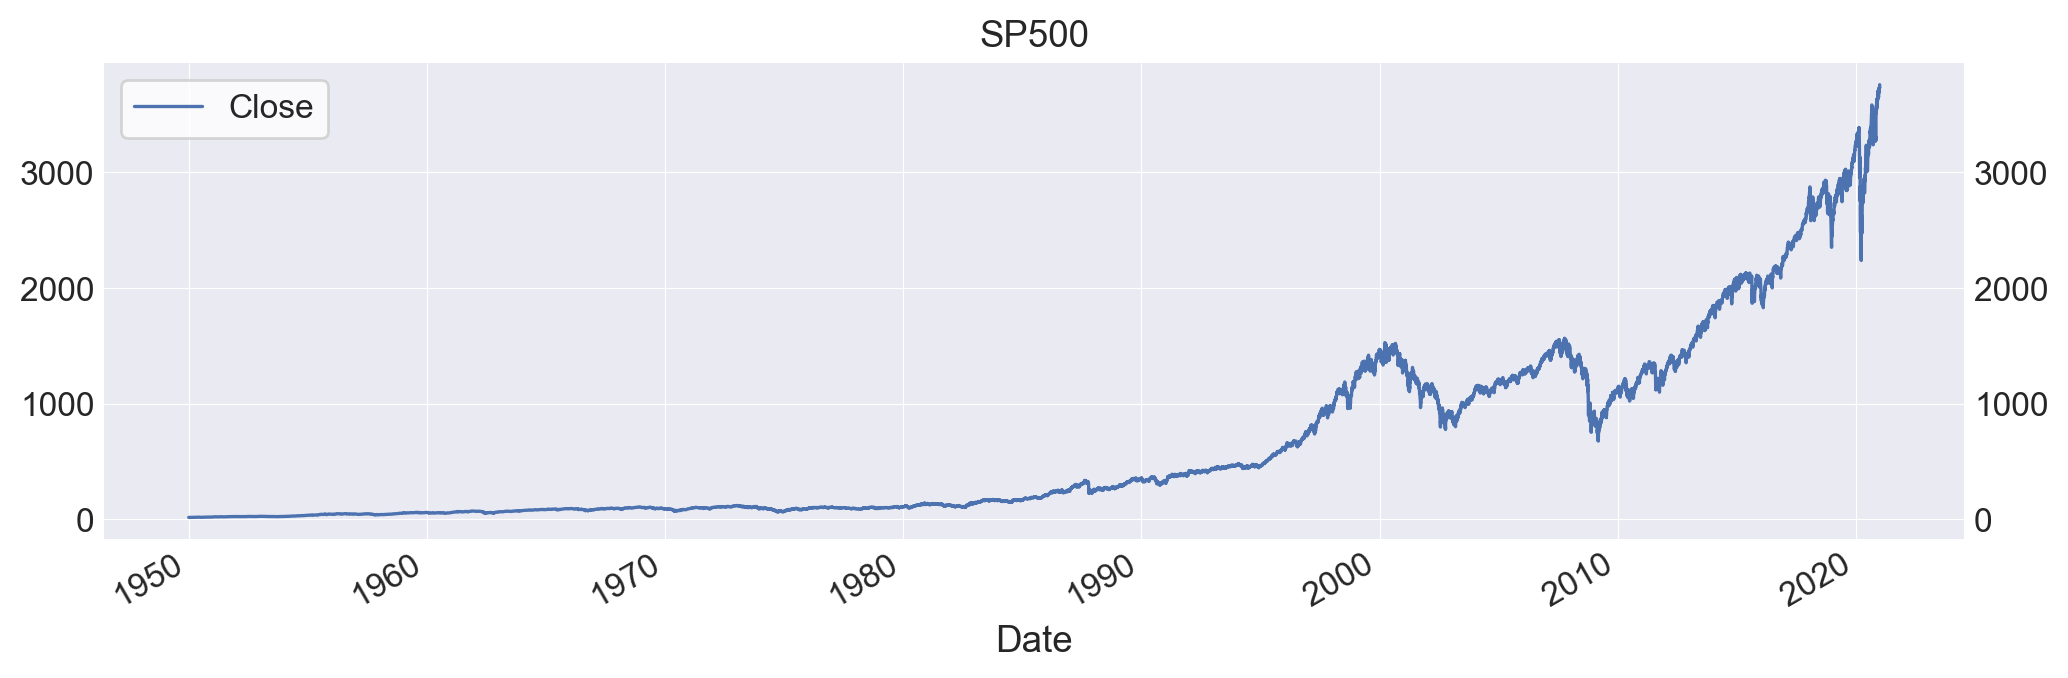

In [5]:
%run Functions.ipynb

#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data = data[['Open', 'Close']]

data['Market_daily_ret'] = data['Close'].pct_change().fillna((data['Close']-data['Open'])/data['Open'])
data = data.loc['1950':'2020' ,['Close', 'Market_daily_ret']]

data.tail()
data['Close'].plot(title='SP500', legend=True)

# WF optimization with memory - 2000:2020

## WF Function

In [6]:
def run_walk_forward_sell_in_may(data, param1_list, param2_list, IS_start, IS_end, OOS_start, OOS_end, memory_len, name=''):
    hide = True
    
    num_neighbors_matrix = get_num_neighbors_sell_in_may_and_go_away(param1_list, param2_list)

    df_wf = data[IS_start[0]:OOS_end[-1]].copy()
    #df_walk_forward = df_walk_forward.loc[:'2020-05-02']

    if hide == True:
        # Copy data and create necessary columns 
        new_cols = ['Strat_daily_ret', 'Strat_position', 'Long_only', 'Costs', 'Market_cum_ret']
        df_wf= df_wf.reindex(columns = df_wf.columns.tolist() + new_cols)

        last_position = 0 # We suppose that we start not being invested. 1:long, -1:short
        
        # Info that we want to save
        indiv_ir_list = []
        robust_ir_list = []
        market_ir_list = []
        weights_list = []
        weights_list.append(np.zeros((len(param1_list),len(param1_list))))
        cummulated_weights_list = []
        sell_month_best_list = []
        sell_duration_best_list = []

        info_wf_str = prepare_wf_info_str(param1_list, param2_list, IS_start, IS_end, OOS_start, OOS_end, memory_len)
        print(info_wf_str)

    for i in trange(len(IS_start), desc='Walk Forward loop:'):    
        #if i == 1: break

        #print(f'{IS_start[i].year} to {IS_end[i].year}')

        is_period = df_wf.loc[IS_start[i]:IS_end[i]].copy()
        oos_period = df_wf.loc[OOS_start[i]:OOS_end[i]].copy()

        ############################################ IN SAMPLE  ############################################
        strat_pnl_matrix, strats_ir_matrix, market_pnl, market_ir = run_all_combinations_sell_in_may(is_period, param1_list, param2_list, last_position)
        indiv_ir_list.append(strats_ir_matrix)
        market_ir_list.append(market_ir)

        # Get the best combination the In-Sample period, or buy_and_hold if it performed better
        best, robust_strats_ir_matrix, IS_weights = get_best_combination_with_memory(strats_ir_matrix, 
                                                                                    weights_list, memory_len, 
                                                                                    market_ir, num_neighbors_matrix,
                                                                                    param1_list, param2_list)

        robust_ir_list.append(robust_strats_ir_matrix)
        weights_list.append(IS_weights)
        cummulated_weights_list.append(np.sum(weights_list[-(memory_len+1):], axis=0))

    #    print("\tParams: {} {}" .format(best['param1'], best['param2']))
        sell_month_best_list.append(best['param1'])
        sell_duration_best_list.append(best['param2'])

        ############################################ OUT OF SAMPLE  ############################################
        strategy = sell_in_may_and_go_away(oos_period, best['param1'], best['param2'])
        oos_period, last_position, strat_pnl, strat_ir, market_pnl, market_ir = backtest_strat(oos_period, strategy, previous_position=last_position)
        #print_backtest_stats(oos_period, strat_pnl, strat_ir, market_pnl, market_ir, strat_params=(best['param1'], best['param2']))

        # Save come columns from OOS
        df_wf.loc[OOS_start[i]:OOS_end[i], new_cols] = oos_period[new_cols]

    #    print()

    # Delete first element from weights_list (it was initialized to 0)
    weights_list = weights_list[1:]

    params_combinations = pd.DataFrame([sell_month_best_list, sell_duration_best_list], index=['sell_month', 'sell_duration'], columns=OOS_start.year)
    
    results = dict()
    results['df'] = prepare_oos_df(df_wf.loc[OOS_start[0]:OOS_end[-1]])
    results['indiv_ir_list'] = indiv_ir_list
    results['market_ir_list'] = market_ir_list
    results['robust_ir_list'] = robust_ir_list
    results['weights_list'] = weights_list
    results['cummulated_weights_list'] = cummulated_weights_list
    results['params_combinations'] = params_combinations
    results['metrics'] = calculate_performance_metrics(results['df'], strat_name=f'{name}list_mem{mem}_IS{IS_end[0].year-IS_start[0].year+1}')
    
    print("End of Walk Forward Optimization")
    
    return results # dict with keys and lists of results

## Definition of parameter combinations

In [7]:
%run Functions.ipynb

memory_len = [0, 2, 4]

sell_month_long_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13]
sell_month_duration_long_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
sell_month_short_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
sell_month_duration_short_list = [1, 2, 3, 4, 5, 6, 13, 13, 13, 13, 13, 13]

IS_start_combination = [pd.date_range(start='1982-01-01', end='2017-01-01', freq='1YS', closed=None), # 3Y IS
                        pd.date_range(start='1980-01-01', end='2015-01-01', freq='1YS', closed=None), # 5Y IS
                        pd.date_range(start='1975-01-01', end='2010-01-01', freq='1YS', closed=None) # 10Y IS
                       ]
IS_end = pd.date_range(start='1984-12-31', end='2019-12-31', freq='1Y', closed=None)
OOS_start = pd.date_range(start='1985-01-01', end='2020-01-01', freq='1YS', closed=None)
OOS_end = pd.date_range(start='1985-12-31', end='2020-12-31', freq='1Y', closed=None)

## Long lists of parameters

In [25]:
%run Functions.ipynb

sell_month_long_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13]
sell_month_duration_long_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

results_long = {}

#for mem in trange(len(memory_len), desc='Running several Walk Forwards:'):    

for mem in memory_len:
    for IS_start in IS_start_combination:
#        info_wf_str = prepare_wf_info_str(sell_month_long_list, sell_month_duration_long_list, IS_start, IS_end, OOS_start, OOS_end, mem)
        #print(info_wf_str)
        res = run_walk_forward_sell_in_may(data, sell_month_long_list, sell_month_duration_long_list,
                                          IS_start, IS_end, OOS_start, OOS_end, mem, name='long')
        results_long[f'longlist_mem{mem}_IS{IS_end[0].year-IS_start[0].year+1}'] = res
results_long.keys()
results_long[list(results_long.keys())[0]].keys()

Running 196 backtests on 
	36 IS rolling windows of 3.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 0 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 5.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 0 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 10.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 0 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 3.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 2 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 5.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 2 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 10.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 2 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 3.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 4 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 5.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 4 IS periods




End of Walk Forward Optimization
Running 196 backtests on 
	36 IS rolling windows of 10.0 years
	36 OOS rolling windows of 1.0 years
->Total of 7128 backtests	Memory of 4 IS periods




End of Walk Forward Optimization


dict_keys(['longlist_mem0_IS3', 'longlist_mem0_IS5', 'longlist_mem0_IS10', 'longlist_mem2_IS3', 'longlist_mem2_IS5', 'longlist_mem2_IS10', 'longlist_mem4_IS3', 'longlist_mem4_IS5', 'longlist_mem4_IS10'])

dict_keys(['df', 'indiv_ir_list', 'market_ir_list', 'robust_ir_list', 'weights_list', 'cummulated_weights_list', 'params_combinations', 'metrics'])

In [26]:
all_names_long = list(results_long.keys())
all_dfs_long = deeper_get(results_long, ['df'])
all_indiv_ir_list_long = deeper_get(results_long, ['indiv_ir_list'])
all_market_ir_list_long = deeper_get(results_long, ['market_ir_list'])
all_robust_ir_list_long = deeper_get(results_long, ['robust_ir_list'])
all_weights_list_long = deeper_get(results_long, ['weights_list'])
all_cummulated_weights_list_long = deeper_get(results_long, ['cummulated_weights_list'])
all_params_combinations_long = deeper_get(results_long, ['params_combinations'])
all_metrics_long = deeper_get(results_long, ['metrics'])
print(f'Number of days: {len(all_dfs_long[0])}')

Number of days: 9075


longlist_mem0_IS3: 	AbsRet: 779.0 	IR: 0.39
longlist_mem0_IS5: 	AbsRet: 741.0 	IR: 0.37
longlist_mem0_IS10: 	AbsRet: 698.0 	IR: 0.39
longlist_mem2_IS3: 	AbsRet: 658.0 	IR: 0.36
longlist_mem2_IS5: 	AbsRet: 341.0 	IR: 0.23
longlist_mem2_IS10: 	AbsRet: 618.0 	IR: 0.37
longlist_mem4_IS3: 	AbsRet: 608.0 	IR: 0.35
longlist_mem4_IS5: 	AbsRet: 474.0 	IR: 0.31
longlist_mem4_IS10: 	AbsRet: 526.0 	IR: 0.33


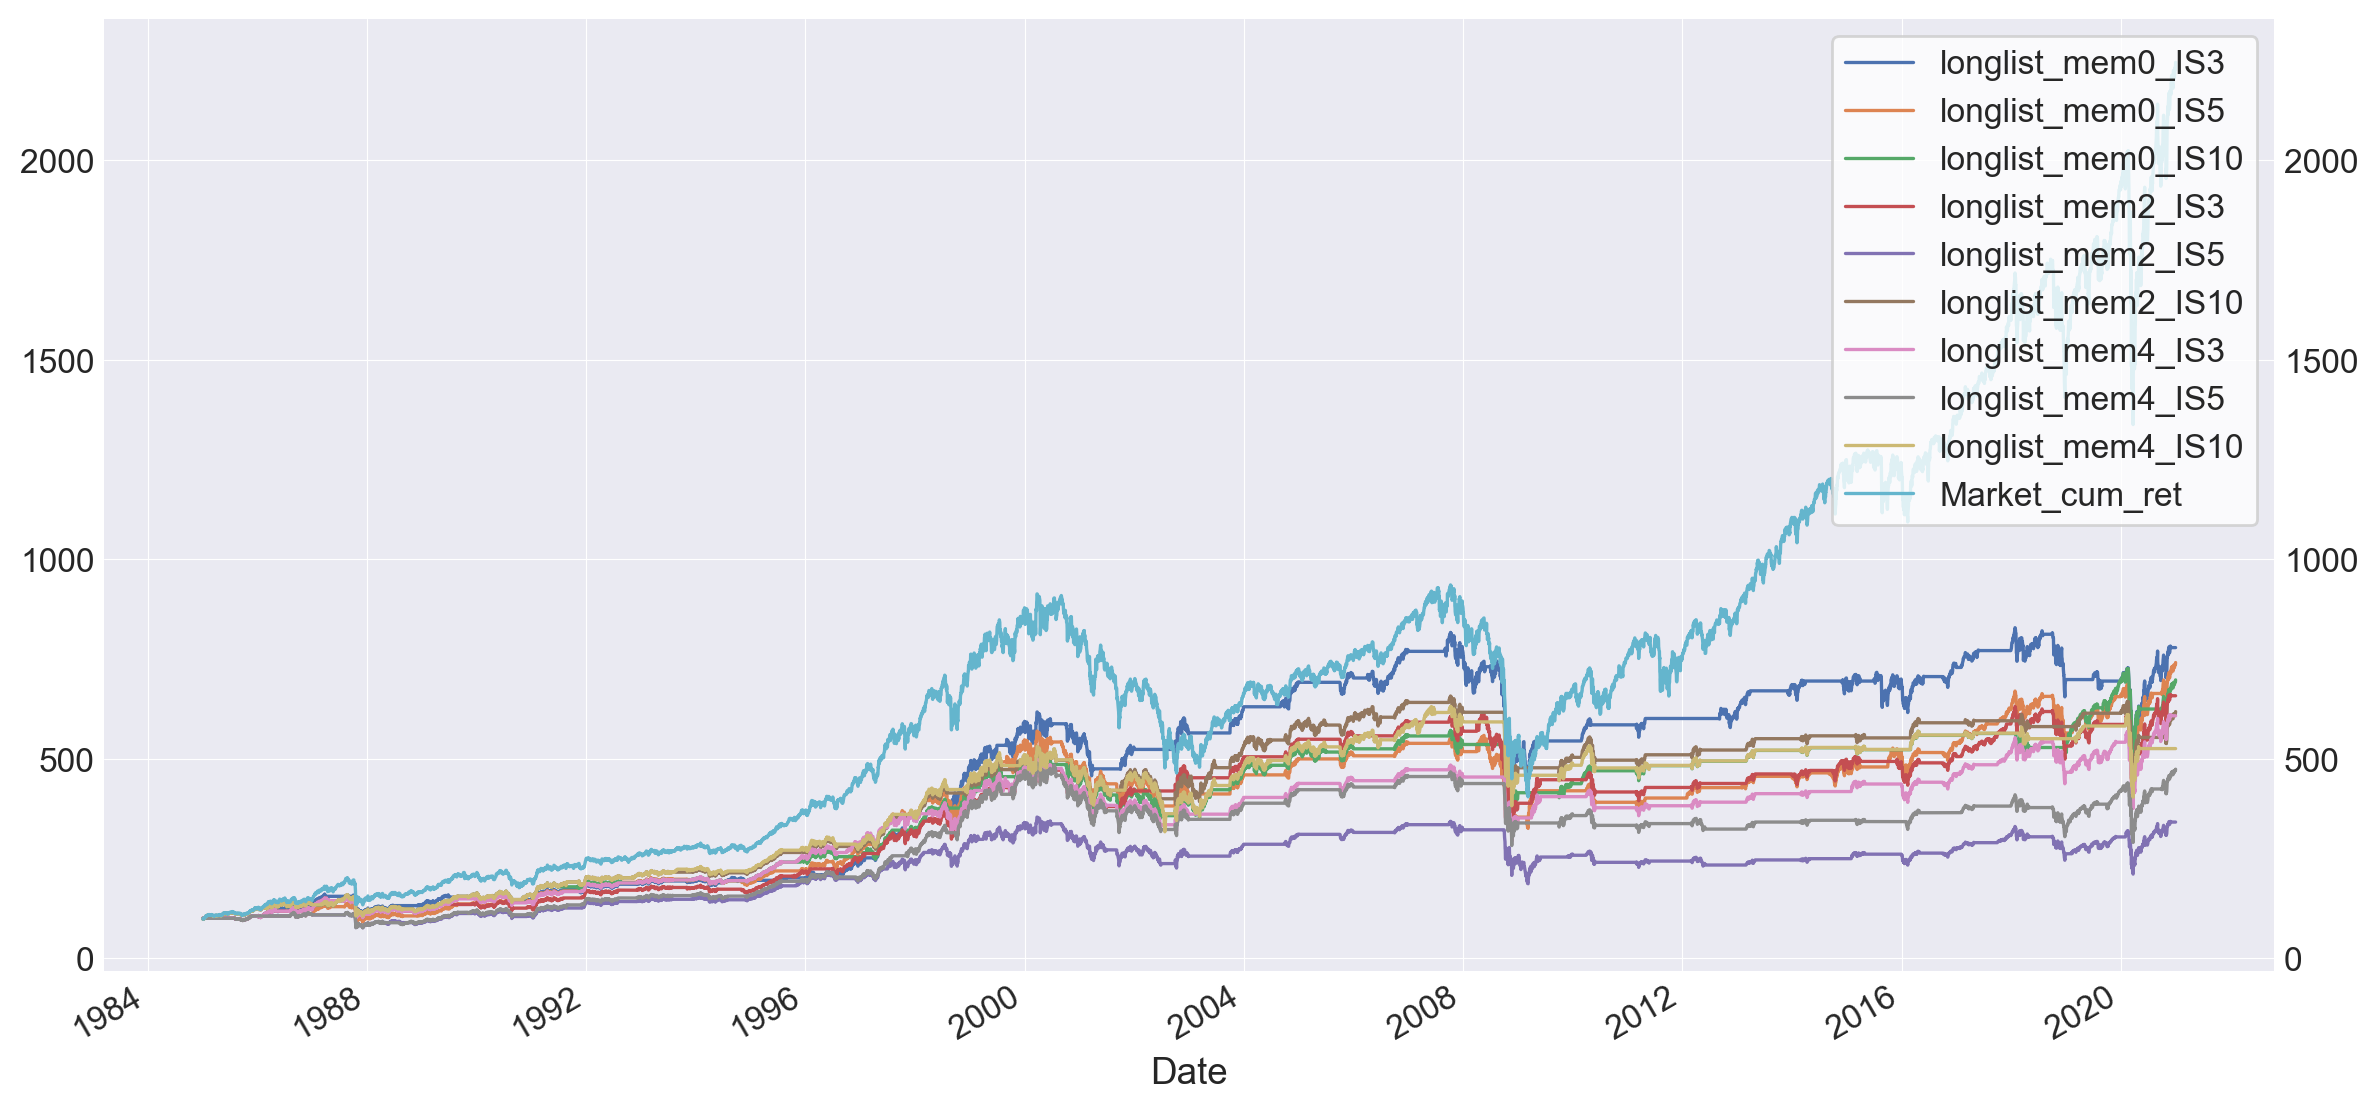

In [27]:
for df, m, strat_name in zip(all_dfs_long, all_metrics_long, all_names_long):
    absret = df['Strat_cum_ret'].iloc[-1].round(0)
    ir = m['IR'].iloc[0].round(2)
    print(f'{strat_name}: \tAbsRet: {absret} \tIR: {ir}')
    _ = df['Strat_cum_ret'].plot(label=strat_name, legend=True, figsize=(14,7))
_ = df['Market_cum_ret'].plot()
plt.legend(loc='upper right')
plt.show()

Let´s check the duration of month being out of the market:
We can see how, ¿too many times?, strategy chooses combinations of parameters being most of the time out of the market. This may happen because the strategy chooses to go long ONLY during the most profitable months (of the IS), instead of penalizing ONLY month with most negative returns.

<AxesSubplot:ylabel='Frequency'>

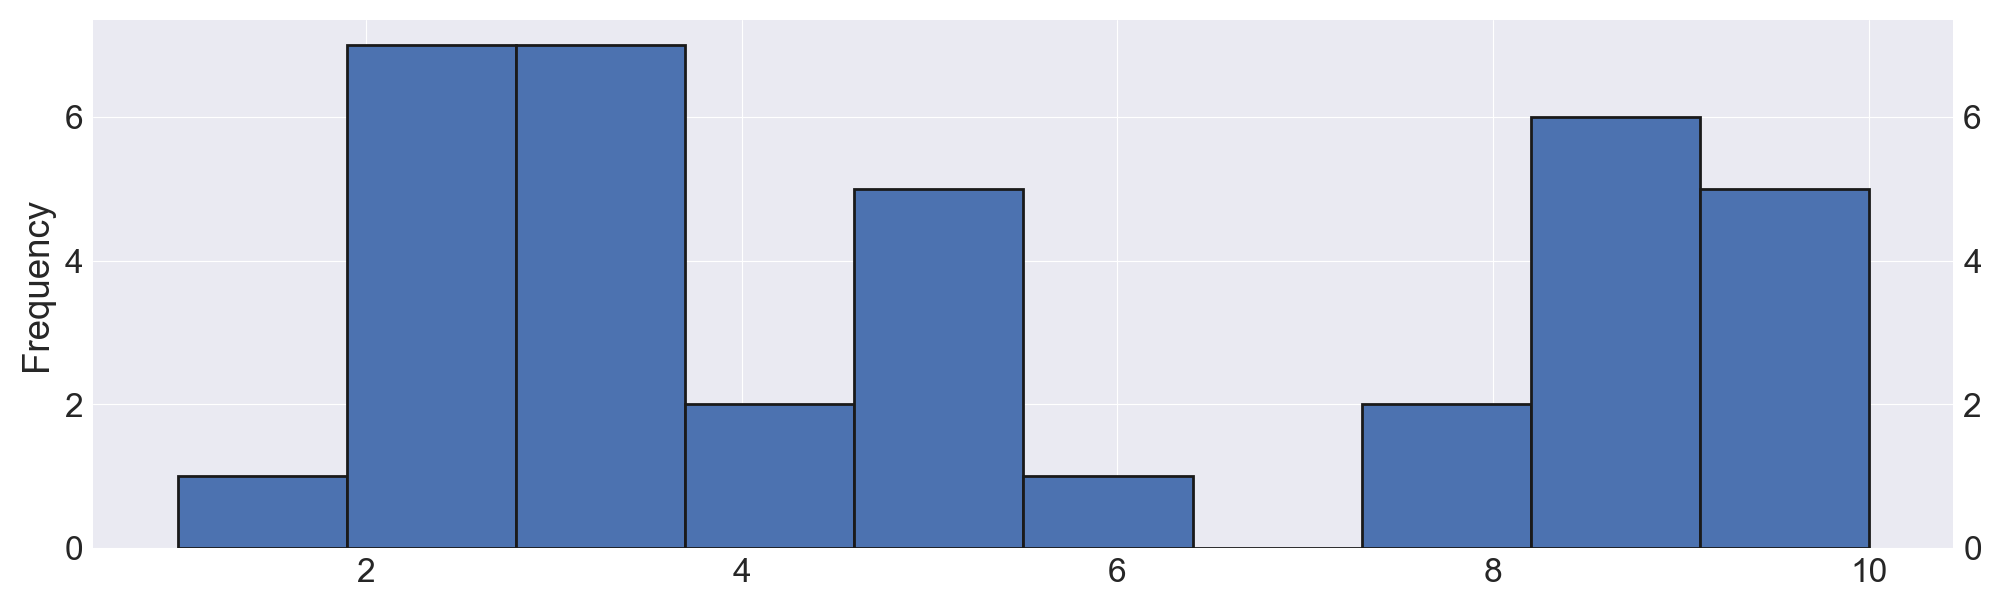

In [28]:
all_params_combinations_long[3].T['sell_duration'].plot(kind='hist')

## Short lists of parameters

In [29]:
%run Functions.ipynb

sell_month_short_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
sell_month_duration_short_list = [1, 2, 3, 4, 5, 6, 13, 13, 13, 13, 13, 13]

results_short = {}

#for mem in trange(len(memory_len), desc='Running several Walk Forwards:'):    

for mem in memory_len:
    for IS_start in IS_start_combination:
#        info_wf_str = prepare_wf_info_str(sell_month_short_list, sell_month_duration_short_list, IS_start, IS_end, OOS_start, OOS_end, mem)
        #print(info_wf_str)
        res = run_walk_forward_sell_in_may(data, sell_month_short_list, sell_month_duration_short_list,
                                          IS_start, IS_end, OOS_start, OOS_end, mem, name='short')
        results_short[f'shortlist_mem{mem}_IS{IS_end[0].year-IS_start[0].year+1}'] = res
results_short.keys()
results_short[list(results_short.keys())[0]].keys()

Running 144 backtests on 
	36 IS rolling windows of 3.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 0 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 5.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 0 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 10.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 0 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 3.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 2 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 5.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 2 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 10.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 2 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 3.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 4 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 5.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 4 IS periods




End of Walk Forward Optimization
Running 144 backtests on 
	36 IS rolling windows of 10.0 years
	36 OOS rolling windows of 1.0 years
->Total of 5256 backtests	Memory of 4 IS periods




End of Walk Forward Optimization


dict_keys(['shortlist_mem0_IS3', 'shortlist_mem0_IS5', 'shortlist_mem0_IS10', 'shortlist_mem2_IS3', 'shortlist_mem2_IS5', 'shortlist_mem2_IS10', 'shortlist_mem4_IS3', 'shortlist_mem4_IS5', 'shortlist_mem4_IS10'])

dict_keys(['df', 'indiv_ir_list', 'market_ir_list', 'robust_ir_list', 'weights_list', 'cummulated_weights_list', 'params_combinations', 'metrics'])

In [30]:
all_names_short = list(results_short.keys())
all_dfs_short = deeper_get(results_short, ['df'])
all_indiv_ir_list_short = deeper_get(results_short, ['indiv_ir_list'])
all_market_ir_list_short = deeper_get(results_short, ['market_ir_list'])
all_robust_ir_list_short = deeper_get(results_short, ['robust_ir_list'])
all_weights_list_short = deeper_get(results_short, ['weights_list'])
all_cummulated_weights_list_short = deeper_get(results_short, ['cummulated_weights_list'])
all_params_combinations_short = deeper_get(results_short, ['params_combinations'])
all_metrics_short = deeper_get(results_short, ['metrics'])
print(f'Number of days: {len(all_dfs_short[0])}')

Number of days: 9075


shortlist_mem0_IS3: 	AbsRet: 997.0 	IR: 0.41
shortlist_mem0_IS5: 	AbsRet: 764.0 	IR: 0.36
shortlist_mem0_IS10: 	AbsRet: 913.0 	IR: 0.39
shortlist_mem2_IS3: 	AbsRet: 766.0 	IR: 0.36
shortlist_mem2_IS5: 	AbsRet: 494.0 	IR: 0.28
shortlist_mem2_IS10: 	AbsRet: 1032.0 	IR: 0.43
shortlist_mem4_IS3: 	AbsRet: 657.0 	IR: 0.33
shortlist_mem4_IS5: 	AbsRet: 712.0 	IR: 0.35
shortlist_mem4_IS10: 	AbsRet: 837.0 	IR: 0.39


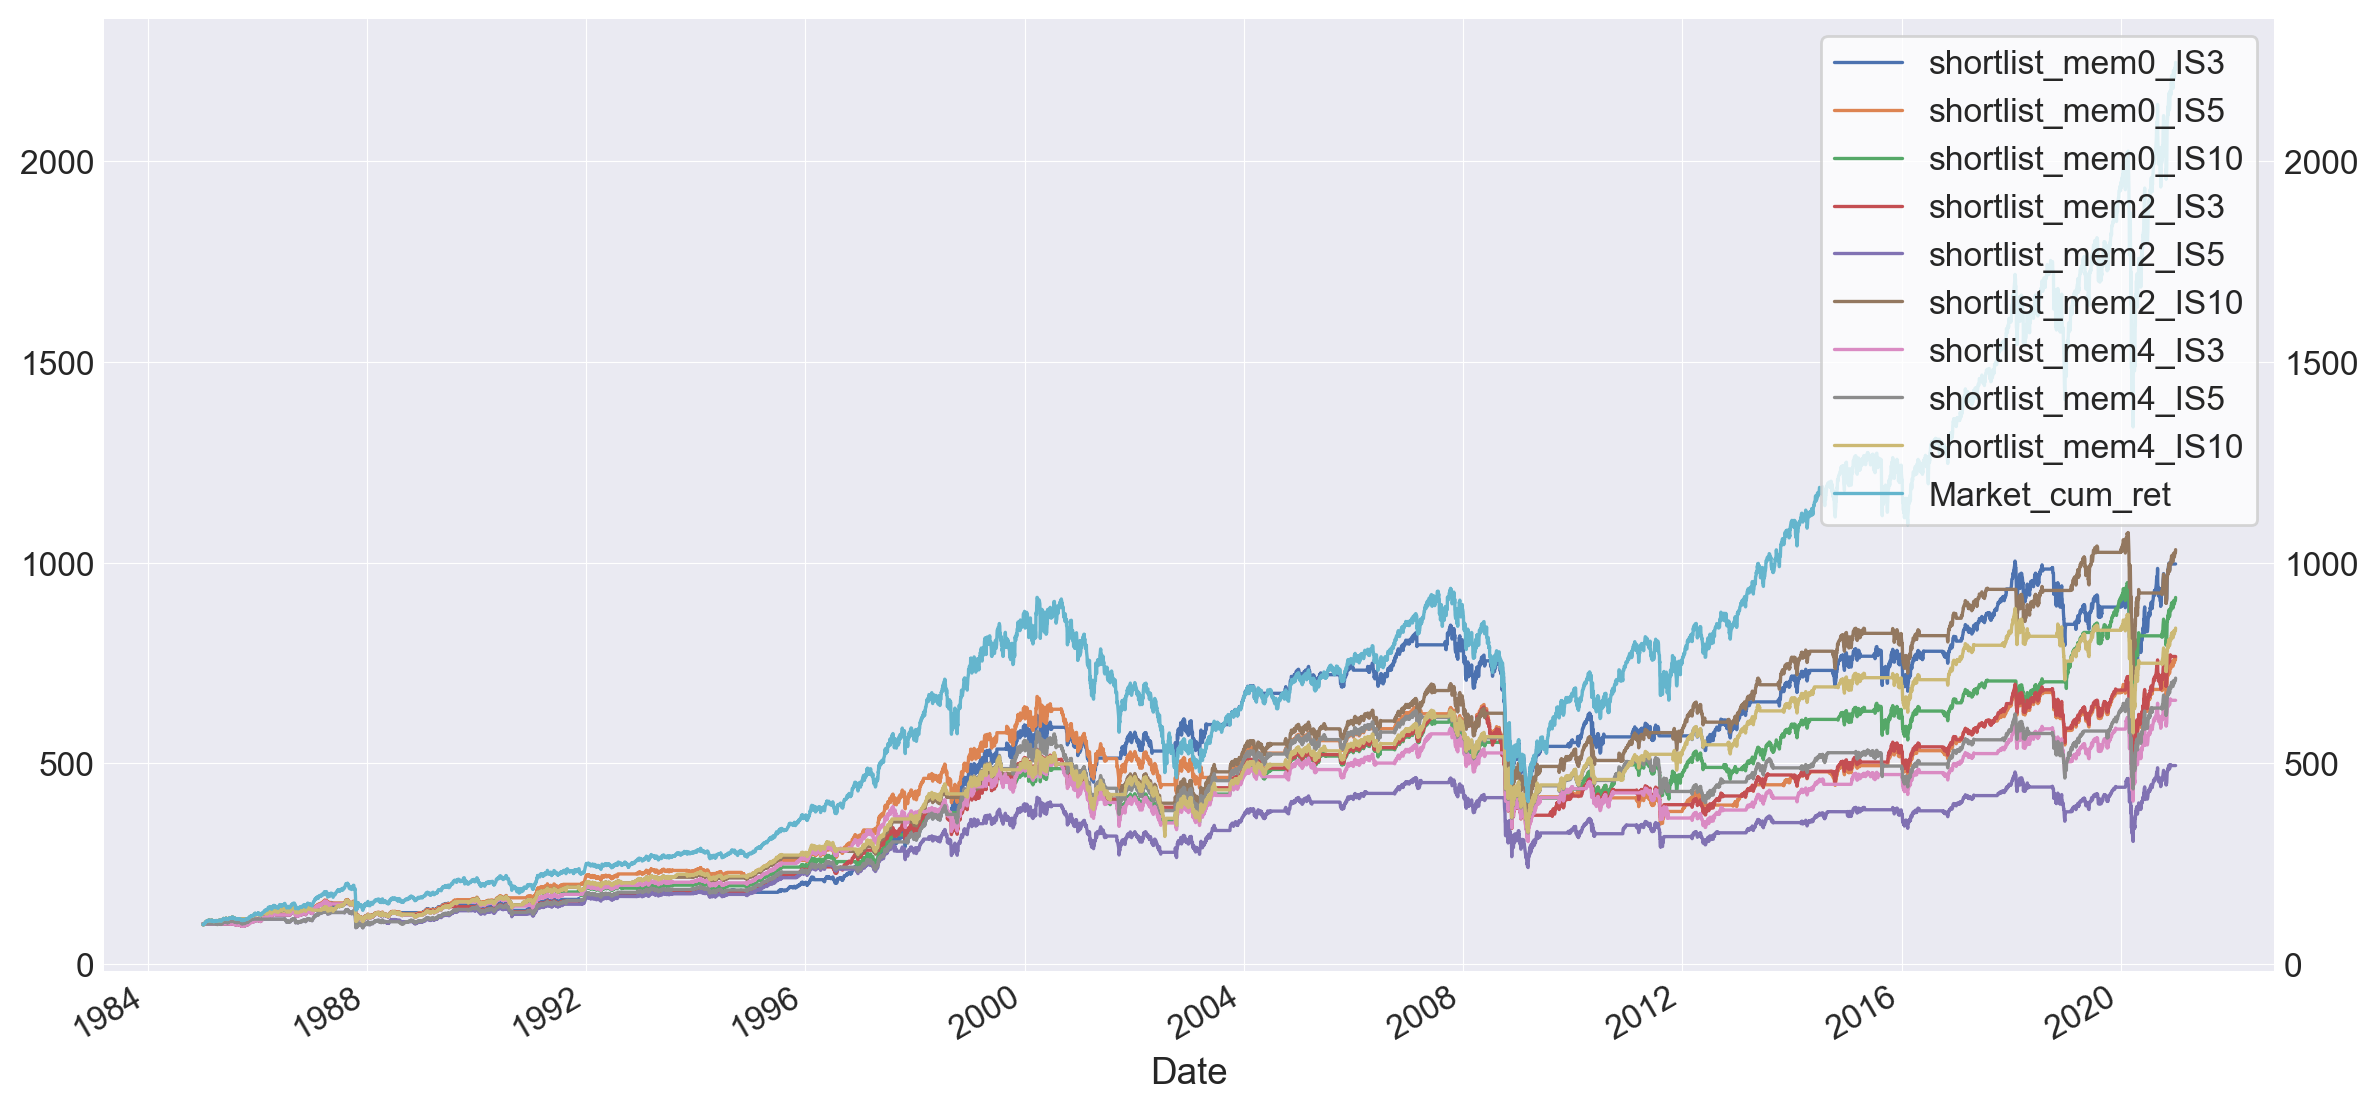

In [31]:
for df, m, strat_name in zip(all_dfs_short, all_metrics_short, all_names_short):
    absret = df['Strat_cum_ret'].iloc[-1].round(0)
    ir = m['IR'].iloc[0].round(2)
    print(f'{strat_name}: \tAbsRet: {absret} \tIR: {ir}')
    _ = df['Strat_cum_ret'].plot(label=strat_name, legend=True, figsize=(14,7))
_ = df['Market_cum_ret'].plot()
plt.legend(loc='upper right')
plt.show()

Let´s check the duration of month being out of the market:  
We can see how now we have limited the sell_duration parameter to a maximum of 6 months. The purpose is to try to force the strategy to choose combination in which negative returns happen often.

<AxesSubplot:ylabel='Frequency'>

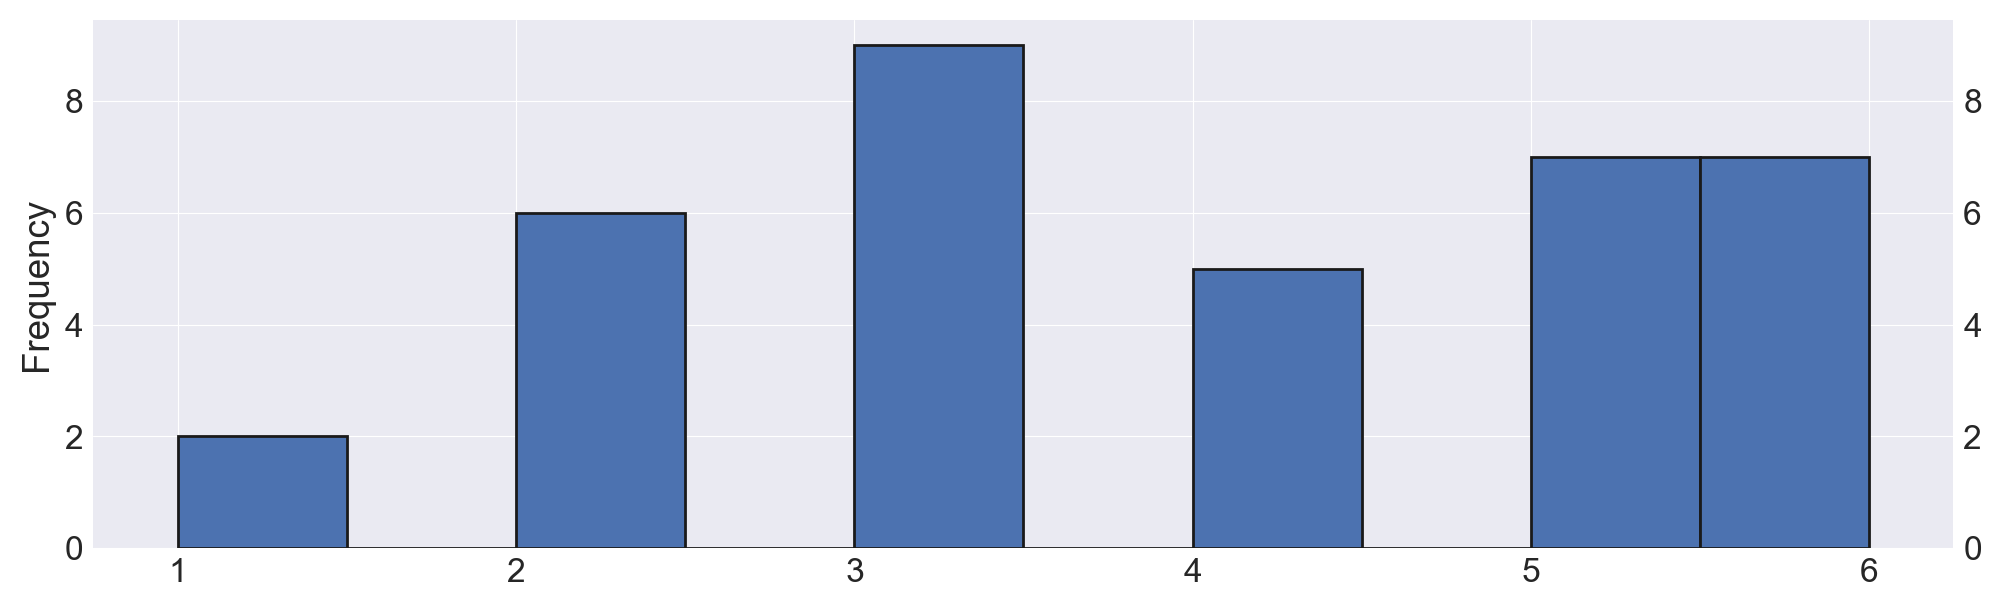

In [32]:
all_params_combinations_short[3].T['sell_duration'].plot(kind='hist')

## Save data

In [59]:
import pickle

with open('data/sell_in_may/results_sell_in_may_short.pickle', 'wb') as file:
    pickle.dump(results_short, file)

with open('data/sell_in_may/results_sell_in_may_long.pickle', 'wb') as file:
    pickle.dump(results_long, file)

# _ = json.dumps(results_short, )
# _ = json.dumps(results_long)

## Comparing long and short performance

In [33]:
metrics = pd.DataFrame()
for m in all_metrics_short:
    metrics = pd.concat([metrics, m])
for m in all_metrics_long:
    metrics = pd.concat([metrics, m])
metrics = metrics.drop_duplicates().sort_index()
metrics.style\
    .background_gradient(cmap='Greens', subset=['AbsRet', 'ARC', 'IR', 'IR**'])\
    .background_gradient(cmap='Reds', subset=['aSD', 'MD', 'AMD', 'MLD', 'All Risk'])

In [35]:
metrics_short = pd.DataFrame()
for m in all_metrics_short:
    metrics_short = pd.concat([metrics_short, m])
metrics_short = metrics_short.drop_duplicates().sort_index()
metrics_short.style\
    .background_gradient(cmap='Greens', subset=['AbsRet', 'ARC', 'IR', 'IR**'])\
    .background_gradient(cmap='Reds', subset=['aSD', 'MD', 'AMD', 'MLD', 'All Risk'])

In [ ]:
def sum_digits(string):
    return string.findAll(/\d+/)*.toLong().sum()
    #return sum(int(x) for x in string if x.isdigit())

In [44]:
test = metrics_short.copy()
test = test.reset_index().rename(columns={"index": "Strat_name"})
#test['total_IS'] = test['Strat_name'].apply(sum_digits)
test

Strat_name     AbsRet     ARC      IR      aSD       MD      AMD      MLD    IR**  All Risk   ARCMD  ARCAMD  Num Trades  Out of market
0         Buy and Hold  2145.9160  9.0251  0.4922  18.3365  56.7754  14.1887   7.1732  0.0782   10.5957  0.1590  0.6361           1              0
1  shortlist_mem0_IS10   813.0405  6.3338  0.3930  16.1185  48.1143  12.4503   7.1075  0.0517    6.8627  0.1316  0.5087          75           2493
2   shortlist_mem0_IS3   896.5400  6.5925  0.4088  16.1249  52.7208  12.0585   9.3908  0.0511    9.6267  0.1250  0.5467          74           3013
3   shortlist_mem0_IS5   663.9120  5.8086  0.3578  16.2339  54.0051  12.7927  17.7960  0.0385   19.9591  0.1076  0.4541          77           2916
4  shortlist_mem2_IS10   932.1538  6.6965  0.4312  15.5311  48.1143  11.6205   5.5934  0.0600    4.8571  0.1392  0.5763          75           2793
5   shortlist_mem2_IS3   666.0832  5.8169  0.3636  15.9973  47.2575  12.5253   9.5250  0.0448    9.0193  0.1231  0.4644          76           2896
6   shortlist_mem2_IS5   394.4332  4.5380  0.2823  16.0747  48.2355  13.0431  10.9049  0.0266   11.0284  0.0941  0.3479          74           3022
7  shortlist_mem4_IS10   736.8237  6.0768  0.3877  15.6719  48.1143  12.2333   5.5934  0.0490    5.1596  0.1263  0.4967          75           2803
8   shortlist_mem4_IS3   556.9684  5.3664  0.3296  16.2821  48.1143  13.0125  10.2861  0.0368   10.4857  0.1115  0.4124          74           2787
9   shortlist_mem4_IS5   612.1614  5.6027  0.3519  15.9204  48.2355  12.8324  12.8433  0.0409   12.6562  0.1162  0.4366          73           2959

In [55]:
sum_digits('shortlist_mem0_IS10')
#test['Strat_name'].apply(sum_digits)

1

## Others

### Heatmaps with widgets

In [19]:
# %run Functions.ipynb
# from ipywidgets import widgets

# options = [year for year in IS_start.year]

# selection_slider = widgets.SelectionSlider(
#     options=options,
#     description='Starting IS year',
#     orientation='horizontal',
#     layout={'width': '900px'},
# )
# selection_slider

# def plot_heatmap(year):
#     index = year - IS_start.year[0]
#     show_both_heatmaps_new(robust_ir_list[index], weights_list[index], market_ir_list[index], 
#                            plot_title=str(year), left_plot_title="Robust IR", right_plot_title="weights",
#                            x_title="Sell duration", x_values=sell_duration_list, y_title="Sell month", y_values=sell_month_list)   

# widgets.interact(
#     plot_heatmap,
#     year=selection_slider
# );

In [20]:
# # %run Functions.ipynb
# from ipywidgets import widgets

# options = [year for year in IS_start.year]

# selection_slider = widgets.SelectionSlider(
#     options=options,
#     description='Starting IS year',
#     orientation='horizontal',
#     layout={'width': '900px'},
# )
# #selection_slider

# def plot_heatmap(year):
#     index = year - IS_start.year[0]
#     print(sell_month_best_list[index], sell_duration_best_list[index])
# #     show_both_heatmaps_new(weights_list[index], 100*cummulated_weights_list[index], market_ir_list[index], 
# #                            plot_title=str(year), left_plot_title="weights", right_plot_title="Cummulative weights",
# #                            x_title="Sell duration", x_values=sell_duration_list, y_title="Sell month", y_values=sell_month_list)
    
#     print(f'Market IR: {market_ir_list[index]}')
#     show_both_heatmaps_new(indiv_ir_list[index], 100*cummulated_weights_list[index], market_ir_list[index], 
#                            plot_title=str(year), left_plot_title="Individual IR", right_plot_title="Cummulative weights",
#                            x_title="Sell duration", x_values=sell_duration_list, y_title="Sell month", y_values=sell_month_list)
# widgets.interact(
#     plot_heatmap,
#     year=selection_slider
# );